In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.simplefilter("ignore")
import joblib
import imblearn

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
pd.set_option('display.max_columns', 100)

In [2]:
data = pd.read_csv("UCI_Credit_Card_Processed.csv")
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment'],
      dtype='object')

In [3]:
data.sample(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
9860,9861,190000.0,2,1,2,25,0,0,0,0,0,0,106223.0,103922.0,106082.0,95645.0,89762.0,91835.0,7500.0,16027.0,9000.0,2919.0,3220.0,22000.0,0
14599,14600,90000.0,2,2,1,34,-2,-2,-2,-2,-2,-2,1905.0,1924.0,11855.0,665.0,0.0,665.0,1924.0,11855.0,10655.0,0.0,665.0,0.0,0
863,864,10000.0,2,2,1,31,0,0,0,0,0,0,15915.0,9050.0,9901.0,9975.0,9736.0,8703.0,2330.0,2200.0,1000.0,333.0,311.0,322.0,0
3539,3540,30000.0,1,3,1,45,2,2,2,3,5,4,25161.0,24476.0,28721.0,31262.0,30217.0,29158.0,0.0,5000.0,3300.0,0.0,0.0,0.0,1
17321,17322,260000.0,2,5,1,33,0,0,-1,-1,0,0,2229.0,3140.0,2740.0,107139.0,105188.0,104418.0,1000.0,2740.0,107139.0,4000.0,4000.0,4696.0,0
21112,21113,290000.0,1,2,1,38,1,2,0,0,0,0,296437.0,192441.0,194158.0,197590.0,187134.0,180887.0,25.0,10013.0,9526.0,6549.0,6373.0,6781.0,0
16599,16600,10000.0,1,2,2,29,0,0,0,0,0,0,9073.0,9036.0,7385.0,7665.0,7817.0,7981.0,1120.0,1117.0,1127.0,279.0,289.0,369.0,0
4942,4943,270000.0,2,1,2,31,-2,-2,-2,-2,-2,-2,973.0,417.0,1593.0,913.0,1471.0,1302.0,592.0,1593.0,913.0,1471.0,1302.0,7107.0,0
9495,9496,130000.0,1,2,2,29,-1,-1,-1,-1,-1,-1,3920.0,3848.0,942.0,942.0,768.0,-174.0,4000.0,942.0,942.0,768.0,0.0,0.0,0
1493,1494,160000.0,1,2,2,43,-1,-1,0,0,0,-1,12458.0,7146.0,11529.0,20860.0,0.0,780.0,7545.0,5000.0,10000.0,0.0,780.0,0.0,0


# Feature Engineering

In [4]:
# Age is continuous, it is best if we could do binning on this
print('Min age:', data['AGE'].min())
print('Max age:', data['AGE'].max())

Min age: 21
Max age: 79


In [5]:
# lets bin this to 6 groups
bins = [20,30,40,50,60,70,80]
labels = list(range(6))
data['AGE'] = pd.cut(data['AGE'], bins=bins, labels=labels, right=False)

# Covert categorical column into integer by extracting the code of the categories
data['AGE'] = data['AGE'].cat.codes
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,1,20000.0,2,2,1,0,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,0,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,1,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,1,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,3,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,1,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,2,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,1,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,2,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [6]:
X = data.drop(columns=['ID','default_payment'])
y = data['default_payment']

# names of features
feature_cols = X.columns.tolist()

# separating out non-amount features
X_num = X.drop(columns=['SEX','EDUCATION','MARRIAGE','AGE'])
num_cols = X_num.columns.tolist()

In [7]:
# check class imbalance
display(data['default_payment'].value_counts())
display(data['default_payment'].value_counts(normalize=True))

0    23364
1     6636
Name: default_payment, dtype: int64

0    0.7788
1    0.2212
Name: default_payment, dtype: float64

As seen from above stat, there's huge class imbalance. Almost 78% fall under non-default category & 22% under default. This is an indicator that we will have to do Imbalance Learning for this modelling.

In the next steps we will be creating UDF for data split, scaling & prediction with different models, with & without SMOTE

In [8]:
def data_split(X, y, imbalance=False):
    # split data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        shuffle=True, stratify=y, random_state=42)
    
    if imbalance:
        # use SMOTE to over sample data
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
    
    return X_train, X_test, y_train, y_test

In [9]:
def standard_scaler(X_train, X_test, numerical_cols):
    # Make copies of dataset
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    # Apply standardization on numerical features only
    for i in numerical_cols:
        sc = StandardScaler().fit(X_train_std[[i]])
        X_train_std[i] = sc.transform(X_train_std[[i]])
        X_test_std[i] = sc.transform(X_test_std[[i]])
    
    return X_train_std, X_test_std

# 1. Logistic Regression

In [10]:
def logistic_regression(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance=imbalance)

    # Rescale data
    X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols=num_cols)
    
    # Instantiate model
    clf_lr = LogisticRegression(random_state=42)
    
    # Fit the model
    clf_lr.fit(X_train_std, y_train)

    # Since this is imbalanced data, accuracy will not be right metric, hence roc_auc score used for performance.
    scores = cross_val_score(clf_lr, X_train_std, y_train, scoring="roc_auc", cv=5)
    roc_auc_lr = np.mean(scores)
    
    if imbalance:
        return "Logistic Regression", "With SMOTE", roc_auc_lr
    else:
        return "Logistic Regression", "Without SMOTE", roc_auc_lr

In [11]:
model_results = []
model_results.append(logistic_regression())
model_results.append(logistic_regression(imbalance=True))

pd.DataFrame(model_results, columns=["Model","SMOTE","ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Logistic Regression,Without SMOTE,0.725559
1,Logistic Regression,With SMOTE,0.797031


As seen from above result, SMOTE yields a better roc_auc score compared to when not using it.

Hence we proceed to Hyperparameter tuning with SMOTE model.

### Hyperparameter Tuning

In [12]:
# Split data with SMOTE 
X_train, X_test, y_train, y_test = data_split(X, y, imbalance=True) 

# Rescale data
X_train_std, X_test_std = standard_scaler(X_train, X_test, numerical_cols=num_cols)

logistic = LogisticRegression(random_state=42)
distributions = dict(penalty=['l1','l2'])
clf = GridSearchCV(logistic, distributions)

lr_best= clf.fit(X_train_std, y_train)   

print(lr_best.best_params_)

{'penalty': 'l2'}


In [13]:
# Finding ROC_AUC score of tuned model on training data
scores_tuned = cross_val_score(lr_best, X_train_std, y_train, scoring="roc_auc", cv=5)
roc_auc_lr_best = np.mean(scores_tuned)

print(f'ROC_AUC score after tuning parameters:{roc_auc_lr_best:.3f}')

ROC_AUC score after tuning parameters:0.797


As seen above, even after Hyperparameter Tuning, roc_auc score didn't improve on training data.

### Model Evaluation

In [14]:
# UDF to compute Precision, Recall and F1 score
def pre_rec_f1(model, X_test, y_test):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')

In [15]:
pre_rec_f1(lr_best, X_test_std, y_test)

Precision:0.368
Recall:0.563
F1 score:0.445


As seen above, Precision, Recall & F1 score are very low. For this case study, Recall score is crucial & was expected to be higher. Hence we conclude that Logistic Regression doesn't perform well on this data.

# 2. Random Forest

In [16]:
def random_forest(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance=imbalance)
    
    # Instantiate model
    clf_rf = RandomForestClassifier()
   
    # Fit the model
    clf_rf.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_rf, X_train, y_train, scoring="roc_auc", cv=5)
    roc_auc_rf = np.mean(scores)
    
    if imbalance:
        return "Random Forest", "With SMOTE", roc_auc_rf
    else:
        return "Random Forest", "Without SMOTE", roc_auc_rf

In [17]:
model_results = []
model_results.append(random_forest())
model_results.append(random_forest(imbalance=True))

pd.DataFrame(model_results, columns=["Model","SMOTE","ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,Random Forest,Without SMOTE,0.762426
1,Random Forest,With SMOTE,0.916000


As seen above, Random Forest has much better roc_auc score compared to Logistic Regression. Again with SMOTE, roc_auc score is higher compared to when not using it. Hence we proceed to Hyperparameter Tuning using SMOTE.

### Hyperparameter Tuning

In [18]:
# Split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance=True)

# Create parameter grid  
param_grid = {
    'max_depth':[60,90,110],
    'min_samples_leaf':[3,4,5],
    'min_samples_split':[8,10,12],
    'n_estimators':[100,200,300]
}

# Instantiate the model
clf_rf = RandomForestClassifier()

# Instantiate grid search model
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid,    
                           cv=3, n_jobs=-1, verbose=1)

# Fit grid search to the data
grid_search.fit(X_train_sm, y_train_sm)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': 110,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [19]:
# Use the best parameters to fit the model
rf_best = RandomForestClassifier(**grid_search.best_params_)   
rf_best.fit(X_train_sm, y_train_sm)

scores_best = cross_val_score(rf_best, X_train_sm, y_train_sm, scoring="roc_auc", cv=5)
roc_auc_best = np.mean(scores_best)

print(f'ROC_AUC training score after tuning for Random Forest:{roc_auc_best:.3f}')

ROC_AUC training score after tuning for Random Forest:0.906


After Hyperparameter Tuning, roc_auc score for Random Forest has reduced slightly.

### Model Evaluation

In [20]:
pre_rec_f1(rf_best, X_test, y_test)

Precision:0.513
Recall:0.513
F1 score:0.513


As seen above, Precision, Recall & F1 score are same, meaning this model provides more balanced results when compared to Logistic Regression.

# 3. XGBoost

In [21]:
def xgboost(imbalance=False):
    # Split data  
    X_train, X_test, y_train, y_test = data_split(X, y, imbalance=imbalance)
    
    # Instantiate model with default parameters
    clf_xgb = XGBClassifier()
    
    # Fit the model
    clf_xgb.fit(X_train, y_train)

    # Use model's default parameters to get cross validation score
    scores = cross_val_score(clf_xgb, X_train, y_train, scoring="roc_auc", cv=5)
    roc_auc_xgb = np.mean(scores)
    
    if imbalance:
        return "XGBoost", "With SMOTE", roc_auc_xgb
    else:
        return "XGBoost", "Without SMOTE", roc_auc_xgb

In [23]:
model_results = []
model_results.append(xgboost())                  
model_results.append(xgboost(imbalance=True))    

pd.DataFrame(model_results, columns=["Model","SMOTE","ROC_AUC Score"])

,Model,SMOTE,ROC_AUC Score
0,XGBoost,Without SMOTE,0.782039
1,XGBoost,With SMOTE,0.857852


As seen above, XGBoost with SMOTE gives better roc_auc score. We will proceed to Hyperparameter Tuning using model with SMOTE.

In [29]:
# Sampling and split data with SMOTE
X_train_sm, X_test, y_train_sm, y_test = data_split(X, y, imbalance=True)

# Number of trees
n_estimators = np.arange(200,1000,200)

# Minimum loss reduction required to make a further partition on a leaf node of the tree
# The larger gamma is, the more conservative the algorithm will be
gamma = np.arange(0.1,0.6,0.1)

# Default 0.3, range(0,1)
learning_rate = np.arange(0.1,0.6,0.1)

# Maximum number of levels in tree
max_depth = list(range(3,8,1))

# Subsample ratio of the training instances.Range(0,1)
subsample = np.arange(0.5,0.9,0.1)

# Subsample ratio of columns when constructing each tree. Range(0,1)
colsample_bytree = np.arange(0.5,0.9,0.1)

# Control the balance of positive and negative weights
# Sum(negative instances) / sum(positive instances)
scale_pos_weight = [1,3.5]


# Create the random grid
random_grid_xgb = {'n_estimators':n_estimators,
                   'gamma':gamma,
                   'learning_rate':learning_rate,
                   'max_depth':max_depth,
                   'subsample':subsample,
                   'colsample_bytree':colsample_bytree,
                   'scale_pos_weight':scale_pos_weight
                   }
print(random_grid_xgb )

{'n_estimators': array([200, 400, 600, 800]), 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'max_depth': [3, 4, 5, 6, 7], 'subsample': array([0.5, 0.6, 0.7, 0.8]), 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8]), 'scale_pos_weight': [1, 3.5]}


In [30]:
xgboost = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator=xgboost, 
                                param_distributions=random_grid_xgb, 
                                n_iter=100, 
                                cv=3, 
                                verbose=1, 
                                random_state=42, 
                                n_jobs=-1,
                                scoring='roc_auc')


xgb_random.fit(X_train_sm, y_train_sm)   

print(xgb_random.best_params_, xgb_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'subsample': 0.6, 'scale_pos_weight': 3.5, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7999999999999999} 0.8975064505236273


As seen above, XGBoost gives roc_auc score of 0.898 after Hyperparameter Tuning.

In [32]:
pre_rec_f1(xgb_random, X_test, y_test)

Precision:0.437
Recall:0.522
F1 score:0.476


Looking at Precision & Recall of this model, although Recall is higher than Random Forest, Precision is lower.

# Models Comparison
### Confusion Matrix

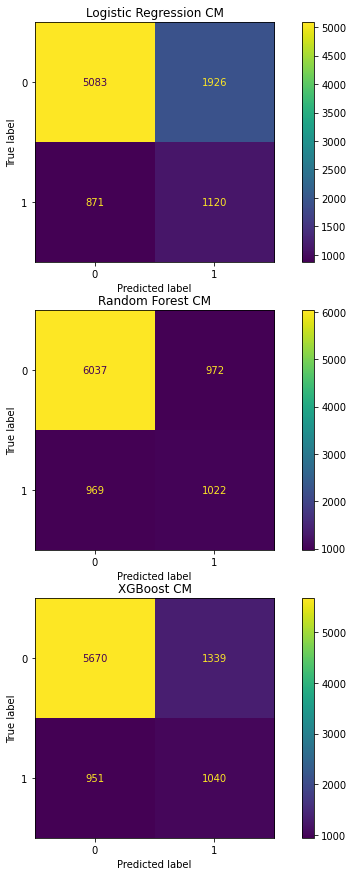

In [33]:
# Plot confusion matrix of 3 models
fig, ax = plt.subplots(3, 1, figsize=(10,15))

plot_confusion_matrix(lr_best, X_test_std, y_test, ax=ax[0], values_format="d")
ax[0].set_title("Logistic Regression CM");

plot_confusion_matrix(rf_best, X_test, y_test, ax=ax[1], values_format="d")
ax[1].set_title("Random Forest CM");

plot_confusion_matrix(xgb_random, X_test, y_test, ax=ax[2], values_format="d")
ax[2].set_title("XGBoost CM");

### ROC_AUC Curve

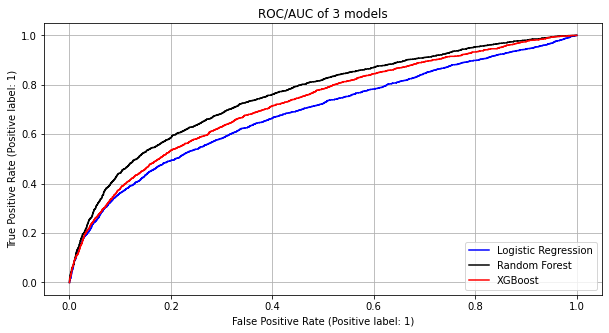

In [35]:
# Plot ROC_AUC curve of 3 models
fig, ax = plt.subplots(figsize=(10,5))

plot_roc_curve(lr_best, X_test_std, y_test, ax=ax, color="blue", label='Logistic Regression')
plot_roc_curve(rf_best, X_test, y_test, ax=ax, color="black", label='Random Forest')
plot_roc_curve(xgb_random, X_test, y_test, ax=ax, color="red", label='XGBoost')

plt.title('ROC/AUC of 3 models')
plt.grid()

### Precision_Recall Curve

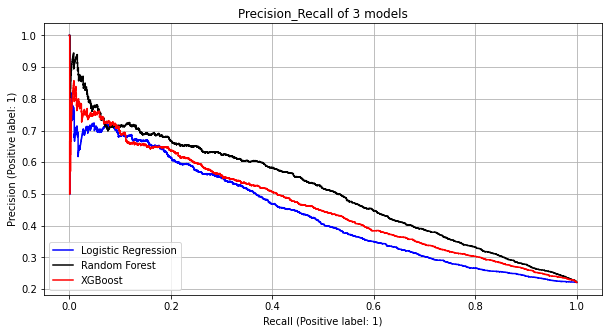

In [37]:
# Compare 3 models' Precision_recall curves
fig, ax = plt.subplots(figsize=(10,5))

plot_precision_recall_curve(lr_best, X_test_std, y_test, ax=ax, color="blue", label='Logistic Regression')
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax, color="black", label='Random Forest')
plot_precision_recall_curve(xgb_random, X_test, y_test, ax=ax, color="red", label='XGBoost')

plt.title('Precision_Recall of 3 models')
plt.grid()

### Comparing Models Result with DummyClassifier

In [38]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
y_pred_dummy = dummy_clf.predict(X_test)

print('Dummy model metrics:')
pre_rec_f1(dummy_clf, X_test, y_test)

Dummy model metrics:
Precision:0.218
Recall:0.495
F1 score:0.303


From above scores, our 3 models, Logistic Regression, Random Forest & XGBoost have outperformed Dummy model.

Although Logistic Regression has highest Recall score, but Random Forest has a better balance of Precision_Recall score. Hence Random Forest can be chosen as the best model for this case.

### Feature Importances

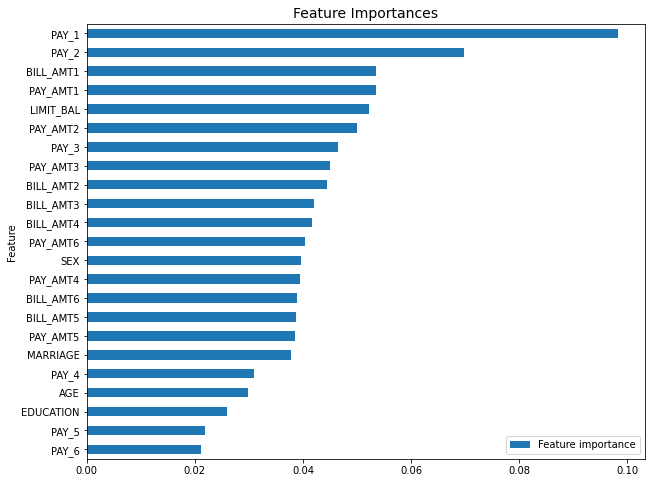

In [39]:
# Plot feature importance of selected model - Random Forest
fea_df = pd.DataFrame({'Feature':feature_cols, 'Feature importance':rf_best.feature_importances_})
fea_df = fea_df.sort_values(by='Feature importance')

fig, ax = plt.subplots(figsize=(10,8))
fea_df.plot.barh(x='Feature', y='Feature importance', ax=ax)
plt.title('Feature Importances', fontsize=14);

From above chart, we see that PAY_1 & PAY_2 are the strongest predictors of default_payment. As per data description the mentioned features are the most recent 2 months payment status, this seem to be logically correct.

# Conclusion

Logistic Regression model has the highest recall but the lowest precision. If the business cares recall the most, then this model is the best candidate.
If the balance of recall and precision is the most important metric, then Random Forest is the ideal model.